# Predicción del estrés financiero

In [1]:
IN_FILE = f'../data/product/product-ffu.xlsx'
OUT_FILE_SUFIX = f"../results/aicode-nfv-ffu_data"

In [2]:
#---
import sys; sys.path.append('../')
from constants.aicode import *

# Librerías

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

#from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance


%matplotlib inline

# Carga del dataset

In [4]:
#pip install openpyxl

In [5]:
dataset = pd.read_excel(IN_FILE, engine='openpyxl')
dataset

,TD_div_TA,WC_div_TA,EBITDA_div_TA,lnTA,isFamiliar,z_cat
0,0.625639,0.191468,0.030919,19.710178,0,1
1,0.140025,0.292908,0.178364,18.660925,0,0
2,0.221861,0.370248,0.090879,18.385202,1,0
3,0.635556,0.292989,0.064907,17.903484,1,1
4,0.294878,0.317507,0.026602,17.891653,1,0
...,...,...,...,...,...,...
196,0.764067,0.069767,0.046522,12.719271,1,0
197,0.701952,0.434562,0.239619,11.976667,1,0
198,0.517596,0.512058,0.196798,12.290730,1,0
199,0.286977,0.344796,-0.077330,13.866345,1,1


In [6]:
X = pd.DataFrame(dataset[dataset.columns[:-2]])
Y = dataset[dataset.columns[-1]]

In [7]:
X.head()

,TD_div_TA,WC_div_TA,EBITDA_div_TA,lnTA
0,0.625639,0.191468,0.030919,19.710178
1,0.140025,0.292908,0.178364,18.660925
2,0.221861,0.370248,0.090879,18.385202
3,0.635556,0.292989,0.064907,17.903484
4,0.294878,0.317507,0.026602,17.891653


In [8]:
Y.head()

0    1
1    0
2    0
3    1
4    0
Name: z_cat, dtype: int64

# Métricas

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score, recall_score

recall_scorer = make_scorer(recall_score, pos_label=1,labels=[0,1])
spec_scorer = make_scorer(recall_score, pos_label=0,labels=[0,1])
pr_auc_scorer = make_scorer(average_precision_score)

accuracy = []
f1 = []
precision = []
recall = []
spec=[]
roc_auc = []
prec_rec = []

dicci = {"accuracy":"accuracy", "average_precision":pr_auc_scorer,
         "f1":"f1", "precision":"precision", "recall":recall_scorer,
         "spec":spec_scorer,"roc_auc":"roc_auc"}

def score(scores):
    accuracy.append(str(np.around(np.mean(scores.get("test_accuracy")),3)) + " ("
                + str(np.around(np.std(scores.get("test_accuracy")), 3))+ ")")
    f1.append(str(np.around(np.mean(scores.get("test_f1")),3)) + " ("
                + str(np.around(np.std(scores.get("test_f1")), 3))+ ")")
    precision.append(str(np.around(np.mean(scores.get("test_precision")),3)) + " ("
                + str(np.around(np.std(scores.get("test_precision")), 3))+ ")")
    recall.append(str(np.around(np.mean(scores.get("test_recall")),3)) + " ("
                + str(np.around(np.std(scores.get("test_recall")), 3))+ ")")
    spec.append(str(np.around(np.mean(scores.get("test_spec")),3)) + " ("
                + str(np.around(np.std(scores.get("test_spec")), 3))+ ")")
    roc_auc.append(str(np.around(np.mean(scores.get("test_roc_auc")),3)) + " ("
                + str(np.around(np.std(scores.get("test_roc_auc")), 3))+ ")")

# utils

In [10]:
def model_analysis(model, param_grid, *, scaler, method='std'):
	global RANDOM_STATE, PRIORIZE

# scaler ---------------------------------------------------------------------------------------------------------------
	if scaler: pipe = Pipeline([('scaler', scaler), ('model', model())])
	else: pipe = Pipeline([('scaler', scaler), ('model', model())])

# get best params ------------------------------------------------------------------------------------------------------
	kf = folder()
	grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=PRIORIZE, n_jobs=-1)
	grid.fit(X,Y)

	pipe = grid.best_estimator_
	best_params = {k.split('__')[1]: v for k, v in grid.best_params_.items() if k.startswith('model__')}

	if method == 'fast' : return scores, predicciones, prediccionesproba, pipe.named_steps['model']


# importance -----------------------------------------------------------------------------------------------------------
	kf = folder()
	acc_imp = np.zeros(X.shape[1])

	if scaler: pipe = Pipeline([('scaler', scaler), ('model', model(**best_params))])
	else: pipe = Pipeline([('scaler', scaler), ('model', model(**best_params))])


	for train_idx, test_idx in kf.split(X, Y):
		x_train, x_val = X.iloc[train_idx], X.iloc[test_idx]
		y_train, y_val = Y.iloc[train_idx], Y.iloc[test_idx]

		pipe.fit(x_train, y_train)

		acc_imp += permutation_importance(pipe, x_val, y_val, n_repeats=10, random_state=RANDOM_STATE).importances_mean

	importances = acc_imp / kf.get_n_splits()

# train  ---------------------------------------------------------------------------------------------------------------
	if scaler: pipe = Pipeline([('scaler', scaler), ('model', model(**best_params))])
	else: pipe = Pipeline([('scaler', scaler), ('model', model(**best_params))])

	pipe.fit(X, Y)

# analysis -------------------------------------------------------------------------------------------------------------
	scores = cross_validate(pipe, X, Y, scoring=dicci)
	predicciones = cross_val_predict(pipe, X, Y, cv=cv)
	prediccionesproba = cross_val_predict(pipe, X,Y, cv=cv, method="predict_proba")

	score(scores)

# return ---------------------------------------------------------------------------------------------------------------
	return scores, predicciones, prediccionesproba, pipe.named_steps['model'], importances

# Models analysis

In [11]:
# logistic
scoreslogic, prediccioneslogistic, prediccioneslogisticproba, logistic, perm_imp_logic = model_analysis(lambda **x: LogisticRegressionCV(**x, random_state=RANDOM_STATE), param_grids.logic, scaler=scalers.logic, method=None)
imp_logic = logistic.coef_

print(imp_logic)
print(perm_imp_logic)

[[ 5.02583532 -4.03609689 -5.00274368  0.67695398]]
[ 1.51280488e-01  5.78170732e-02  3.38780488e-02 -1.21951220e-05]


In [12]:
# random forest
scoresrfc, prediccionesrfc, prediccionesrfcproba, rfc, perm_imp_rfc = model_analysis(lambda **x: RandomForestClassifier(**x, random_state=RANDOM_STATE), param_grids.rfc, scaler=scalers.rfc, method=None)
imp_rfc = rfc.feature_importances_

print(imp_rfc)
print(perm_imp_rfc)

[0.64254952 0.14440981 0.12860292 0.08443775]
[0.1495     0.05042683 0.03690244 0.02628049]


In [13]:
# knn
scoresneigh, prediccionesneigh, prediccionesneighproba, knn, perm_imp_knn = model_analysis(lambda **x: KNeighborsClassifier(**x, algorithm='auto'), param_grids.knn, scaler=scalers.knn, method=None)

print(perm_imp_knn)

[0.15469512 0.02585366 0.0019878  0.02181707]


In [14]:
# svc
scoressvm, prediccionessvm, prediccionessvmproba, svc, perm_imp_svc = model_analysis(lambda **x: SVC(**x, random_state=RANDOM_STATE), param_grids.svc, scaler=scalers.svc)
imp_svc = svc.coef_ if svc.get_params()['kernel'] == 'linear' else None

print(imp_svc)
print(perm_imp_svc)

None
[0.12170732 0.07703659 0.03052439 0.00932927]


# Resultados

In [15]:
conjunto1 = pd.DataFrame(columns=["accuracy", "f1_score", "precision","recall","specificity","roc_auc"])
conjunto1["accuracy"] = accuracy
conjunto1["f1_score"] = f1
conjunto1["precision"] = precision
conjunto1["recall"] = recall
conjunto1["specificity"] = spec
conjunto1["roc_auc"] = roc_auc
conjunto1.index = ["LOGIT","RFC", "KNN","SVM"]
#conjunto1.to_csv("conjunto1.csv")

In [16]:
conjunto1

,accuracy,f1_score,precision,recall,specificity,roc_auc
LOGIT,0.831 (0.043),0.72 (0.074),0.754 (0.094),0.697 (0.095),0.892 (0.05),0.905 (0.018)
RFC,0.781 (0.028),0.624 (0.054),0.691 (0.102),0.586 (0.095),0.87 (0.062),0.876 (0.046)
KNN,0.801 (0.025),0.675 (0.044),0.702 (0.06),0.665 (0.099),0.863 (0.061),0.853 (0.024)
SVM,0.796 (0.028),0.687 (0.057),0.667 (0.053),0.729 (0.152),0.827 (0.075),0.9 (0.03)


In [17]:
conprobas = []

conprobas.append(prediccioneslogisticproba)
conprobas.append(prediccionesneighproba)
conprobas.append(prediccionesrfcproba)
conprobas.append(prediccionessvmproba)

In [18]:
clasificadores = ["LOGIT","RFC", "KNN","SVM"]
colores = ["brown","coral","gold","green"]

In [19]:
#roc_auc[0] = '0.805 (0.018)'
#roc_auc[1] = '0.705 (0.038)'
#roc_auc[2] = '0.901 (0.023)'
#roc_auc[3] = '0.890 (0.018)'
#roc_auc[4] = '0.976 (0.008)'
#roc_auc[5] = '0.972 (0.015)'

In [20]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


def plot_roc3(y_true, probis, colores,nombres,title='ROC Curves',
                   plot_micro=True, plot_macro=True, classes_to_plot=None,
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium"):

    y_true = np.array(y_true)
    classes = np.unique(y_true)

    for j in range(len(nombres)):
        probis[j] = np.array(probis[j])
        probas = probis[j]
        if classes_to_plot is None:
            classes_to_plot = classes
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            ax.set_title(title, fontsize=title_fontsize)
        fpr_dict = dict()
        tpr_dict = dict()
        indices_to_plot = np.in1d(classes, classes_to_plot)

        for i, to_plot in enumerate(indices_to_plot):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true, probas[:, i],
                                            pos_label=classes[i])
        if plot_macro:
            ax.plot(fpr_dict[0], tpr_dict[0], label='ROC Curve - ' + nombres[j] + ' - ' + roc_auc[j], color=colores[j], linestyle=':', linewidth=4)
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
        ax.tick_params(labelsize=text_fontsize)
        ax.legend(loc='lower right', fontsize=text_fontsize)
        
    return ax

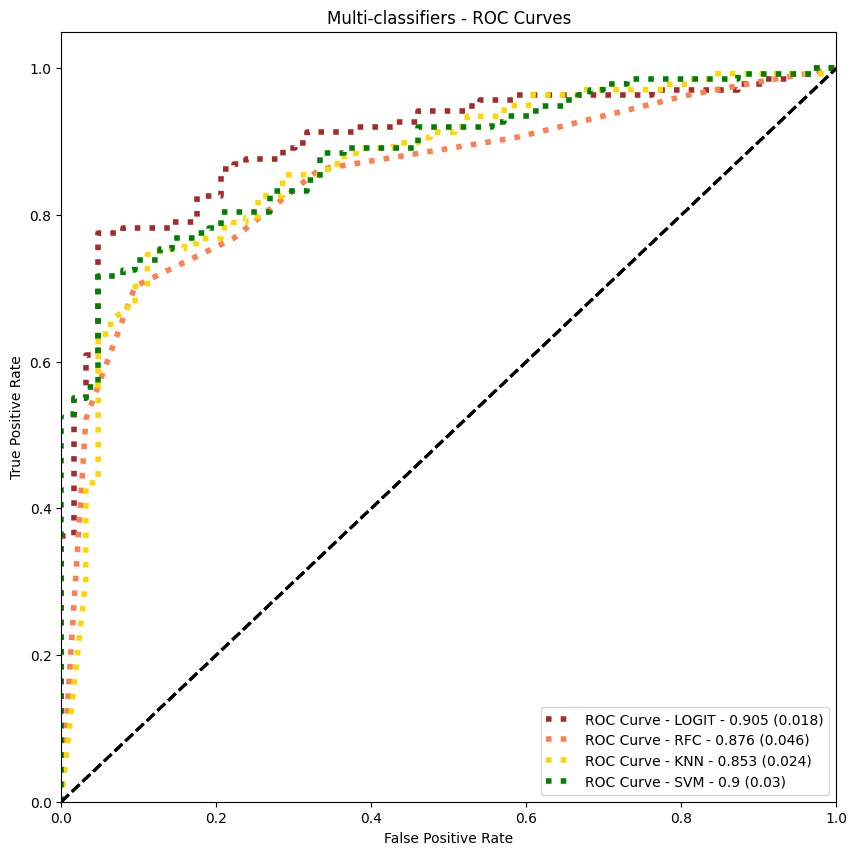

In [21]:
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (10,10)
# plot_roc3(Y, conprobas,TEST2, colores = colores, nombres = clasificadores, title="Multi-classifiers - ROC Curves" )
# plt.show()


import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)
plot_roc3(Y, conprobas, colores = colores, nombres = clasificadores, title="Multi-classifiers - ROC Curves" )
plt.savefig(f"{OUT_FILE_SUFIX}.png")
plt.show()

In [22]:
conjunto1.sort_values(by=ORDER_BY, inplace=True, ascending=False)

conjunto1.to_csv(f"{OUT_FILE_SUFIX}.csv")
conjunto1

,accuracy,f1_score,precision,recall,specificity,roc_auc
LOGIT,0.831 (0.043),0.72 (0.074),0.754 (0.094),0.697 (0.095),0.892 (0.05),0.905 (0.018)
SVM,0.796 (0.028),0.687 (0.057),0.667 (0.053),0.729 (0.152),0.827 (0.075),0.9 (0.03)
KNN,0.801 (0.025),0.675 (0.044),0.702 (0.06),0.665 (0.099),0.863 (0.061),0.853 (0.024)
RFC,0.781 (0.028),0.624 (0.054),0.691 (0.102),0.586 (0.095),0.87 (0.062),0.876 (0.046)
